In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter


# FS 25 Simulations in Science II # 


## Instructions Task 1.0 ## 

- Implement a particle class and a cell class 
- Implement the partitioning of particles function we introduced in class. 
- The hard part is making sure your partition function is really bomb proof, check all "edge cases" (e.g., no particles in the cell, all particles on one side or other of the partition, already partitioned data, particles in the inverted order of the partition, etc...).
- Write boolean test functions for each of these cases.
- Call all test functions in sequence and check if they all succeed.
- Once you have this, then recursively partition the partitions and build cells linked into a tree as you go. Partition alternately in x and y dimensions, or simply partition the longest dimension of the given cell.
- Create a random distribution of particles in 2D and build a tree from the particles.
- Plot the particles and tree cells.

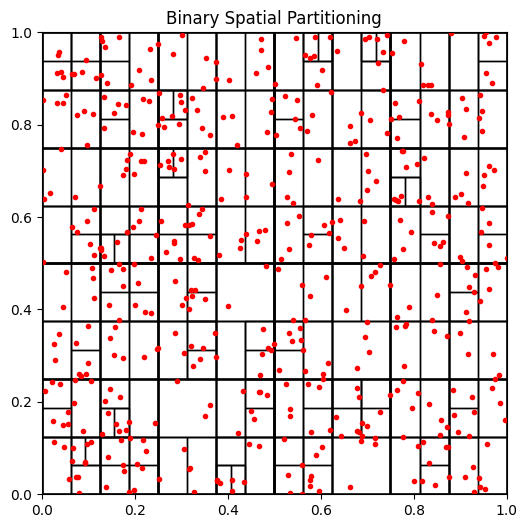

In [4]:
#Create create a number of random point between (0,0) and (1,1)
particles = [Particle(np.random.rand(), np.random.rand()) for _ in range (500)]
# for i in range (10):
#     particles.append(Particle(0.9 + (i * 0.001), 1.0))

root_cell = Cell(0, 0, 1, 1, particles) 

root_cell.split_cell(True, 4)

# Create plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Binary Spatial Partitioning")

# Plot cells and particles
def plot_cells(ax, cell):
    # Draw the cell boundary
    rect = plt.Rectangle(
        (cell.pos_bl_x, cell.pos_bl_y),  # Bottom-left corner
        cell.pos_tr_x - cell.pos_bl_x,   # Width
        cell.pos_tr_y - cell.pos_bl_y,   # Height
        edgecolor='black',
        linewidth=1,
        fill=False
    )
    ax.add_patch(rect)

    # Plot particles as red dots
    for particle in cell.particles:
        x, y = particle.get_pos()
        ax.plot(x, y, 'ro', markersize=3)

    # Recursively plot children
    for sub_cell in cell.children:
        plot_cells(ax, sub_cell)

plot_cells(ax, root_cell)

plt.show()


## TASK 2.0 ##

### Instructions: ###


- Implement the k nearest neighbor search.
- Use the priority queue given in the Python template and implement "replace" and "key" functions.
- Use the particle to cell distance function from the lecture notes or the celldist2() given in the Python template. Are they the same?
- Plot all particles, choose one particle close to the center and one close to the boundary of the box and mark them with a different color as well as the neighbors of them with another color. Also plot a circle around the two chosen particles with the raidus according to the distance to the k-th neighbor

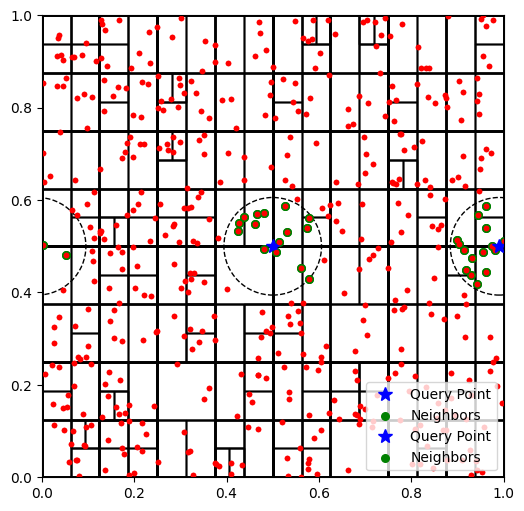

In [5]:
pq = prioq(32)
r1 = np.array([0.5, 0.5])
r2 = np.array([0.99, 0.5])
period = np.array([1, 1])

neighbor_search_periodic(pq, root_cell, r1, period)
neighbor_search_periodic(pq, root_cell, r2, period)

def plot_neighbor_search(ax, root_cell, query_point, period, pq):

    # Plot the tree structure and particles from task 1
    plot_cells(ax, root_cell)

    # Unpack query point
    qx, qy = query_point

    # Plot the query point as a blue star
    ax.plot(qx, qy, 'b*', markersize=10, label="Query Point")

    # Plot periodic images of query point
    for y_offset in [0.0, -period[1], period[1]]:
        for x_offset in [0.0, -period[0], period[0]]:
            if x_offset == 0.0 and y_offset == 0.0:
                continue  # Skip original query point

            qx_shifted, qy_shifted = qx + x_offset, qy + y_offset
            ax.plot(qx_shifted, qy_shifted, 'b', alpha=0.3, markersize=8) 

    # Extract neighbor positions from the priority queue
    neighbor_positions = np.array([parti[1].get_pos() for parti in pq.heap])
    ax.scatter(neighbor_positions[:, 0], neighbor_positions[:, 1], c='green', label="Neighbors", s=30)

    # Draw search radius circles
    search_radius = np.sqrt(-pq.key())
    for y_offset in [0.0, -period[1], period[1]]:
        for x_offset in [0.0, -period[0], period[0]]:
            qx_shifted, qy_shifted = qx + x_offset, qy + y_offset
            ax.add_patch(Circle((qx_shifted, qy_shifted), search_radius, color='k', fill=False, linestyle='dashed'))

    # Final plot adjustments
    ax.set_xlim(0, period[0])
    ax.set_ylim(0, period[1])
    ax.set_aspect('equal')
    ax.legend()
    
fig, ax = plt.subplots(figsize=(6,6))

plot_neighbor_search(ax, root_cell, r1, period, pq)
plot_neighbor_search(ax, root_cell, r2, period, pq)
plt.show()

# Task 3.0 #

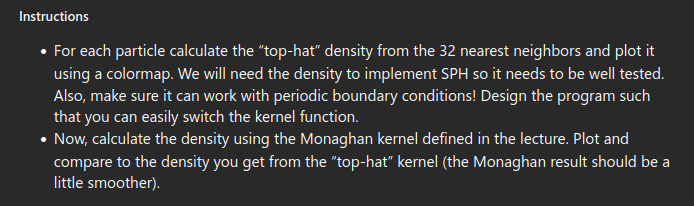

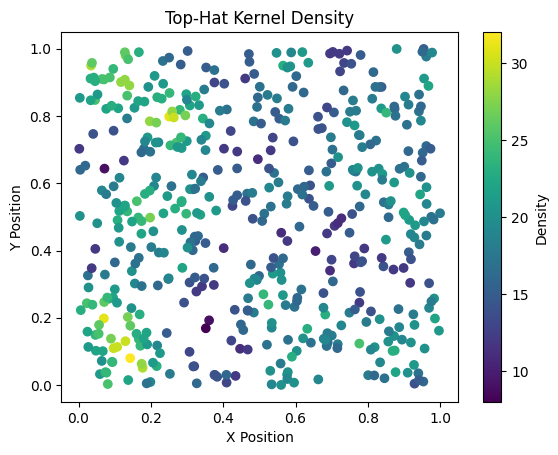

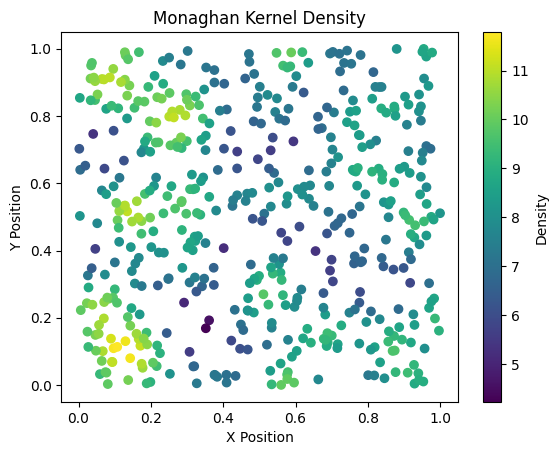

In [6]:
search_radius = np.sqrt(-pq.key())

def plot_density(particles, title):
    x = [particle.pos_x for particle in particles]
    y = [particle.pos_y for particle in particles]
    dens = [particle.dens for particle in particles]
    plt.scatter(x, y, c=dens, cmap='viridis')
    plt.colorbar(label='Density')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()


calculate_density(particles, root_cell, search_radius, top_hat_kernel, period)
plot_density(particles, "Top-Hat Kernel Density")

calculate_density(particles, root_cell, search_radius, monaghan_kernel, period)
plot_density(particles, "Monaghan Kernel Density")

#  Week 04/05 #

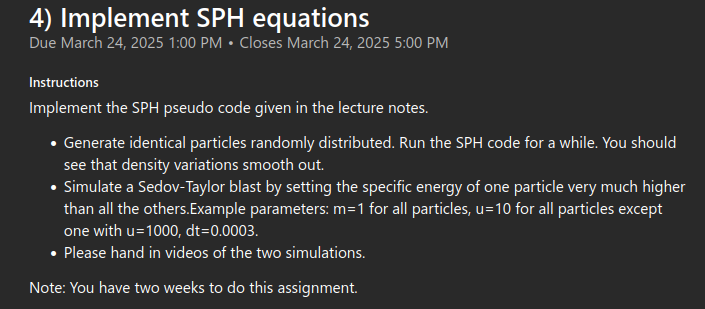

## Defintions ##

speed of sound in ideal gas: 

$ c = \sqrt(\gamma (\gamma - 1) u_i )$ where 

$ \gamma $ = adiabatic index which is the ration between specific heats at constant pressure and volume. For water $ \gamma $ is roughly = 7. 

pressure: 

$ P = (\gamma -1) \rho u $ 



In [ ]:
from utils import *

particles = [Particle(np.random.uniform(0.4, 0.6), np.random.uniform(0.4, 0.6)) for _ in range(200)]
particles[0].energy = 1000
root_cell = Cell(0, 0, 1, 1, particles)
root_cell.split_cell(True, 4)

dt = 0.008
gamma = 7
search_radius = 0.1 #np.sqrt(-pq.key())  # Ensure pq.key() is defined
print(search_radius)
period = [1, 1]  
time_steps = 250

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, period[0])
ax.set_ylim(0, period[1])
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Particle Simulation")

scatter = ax.scatter([p.pos_x for p in particles], [p.pos_y for p in particles], s=10)

def update(frame):
    leapfrog_update(particles, root_cell, search_radius, monaghan_kernel, period, dt, gamma)
    scatter.set_offsets([(p.pos_x, p.pos_y) for p in particles])
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=50, blit=True)
ani.save("animation_sph.mp4", writer="ffmpeg", fps = 10, dpi = 100)
plt.show()

0.1


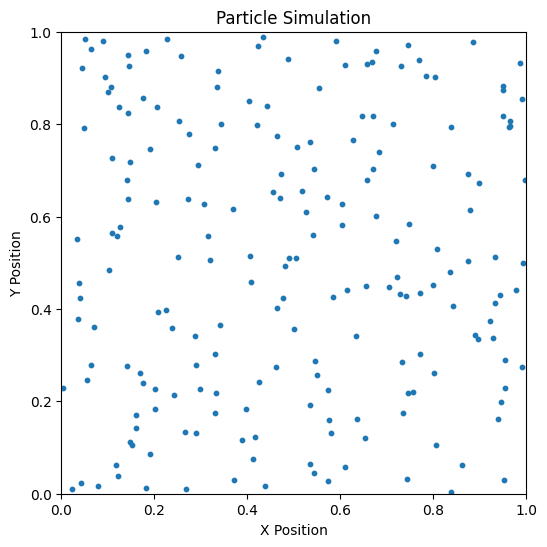

In [14]:
from utils import *

particles = [Particle(np.random.uniform(0.4, 0.6), np.random.uniform(0.4, 0.6)) for _ in range(200)]
root_cell = Cell(0, 0, 1, 1, particles)
root_cell.split_cell(True, 4)

dt = 0.008
gamma = 7
search_radius = 0.1 #np.sqrt(-pq.key())  # Ensure pq.key() is defined
print(search_radius)
period = [1, 1]  
time_steps = 250

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, period[0])
ax.set_ylim(0, period[1])
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Particle Simulation")

scatter = ax.scatter([p.pos_x for p in particles], [p.pos_y for p in particles], s=10)

def update(frame):
    leapfrog_update(particles, root_cell, search_radius, monaghan_kernel, period, dt, gamma)
    scatter.set_offsets([(p.pos_x, p.pos_y) for p in particles])
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=50, blit=True)
ani.save("animation_sph.mp4", writer="ffmpeg", fps = 10, dpi = 100)
plt.show()